In [319]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, recall_score,log_loss, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score , adjusted_mutual_info_score, homogeneity_completeness_v_measure
from sklearn.metrics import roc_curve, auc
from sklearn.utils.multiclass import unique_labels

In [225]:
df = pd.read_csv("Faulty_detect.csv")

#### EDA

In [226]:
df

,Unnamed: 0,Timestamp,Temperature,Sound Frequency,Accel_X,Accel_Y,Accel_Z,Target
0,0,27/09/2024 20:59,28.90,280,0.09,-0.05,1.00,Normal
1,1,27/09/2024 20:59,28.90,374,0.00,0.01,1.02,Normal
2,2,27/09/2024 20:59,28.90,387,-0.02,-0.02,1.01,Normal
3,3,27/09/2024 20:59,28.90,210,-0.03,0.01,1.01,Normal
4,4,27/09/2024 20:59,28.90,258,0.06,-0.03,1.02,Normal
...,...,...,...,...,...,...,...,...
6814,6814,27/09/2024 23:04,43.10,745,0.07,-0.26,0.86,Faulty
6815,6815,27/09/2024 23:04,47.95,938,0.22,-0.15,0.79,Faulty
6816,6816,27/09/2024 23:04,44.05,556,0.03,-0.38,0.86,Faulty
6817,6817,27/09/2024 23:04,40.20,594,0.09,-0.11,1.17,Faulty


In [227]:
df.drop(columns  = ["Unnamed: 0"],inplace = True)

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timestamp        6819 non-null   object 
 1   Temperature      6819 non-null   float64
 2   Sound Frequency  6819 non-null   int64  
 3   Accel_X          6819 non-null   float64
 4   Accel_Y          6819 non-null   float64
 5   Accel_Z          6819 non-null   float64
 6   Target           6819 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 373.0+ KB


In [229]:
df.describe()

,Temperature,Sound Frequency,Accel_X,Accel_Y,Accel_Z
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,31.973345,384.501100,0.092047,-0.108177,1.003147
std,5.151828,249.256389,0.095489,0.089613,0.059166
min,28.200000,75.000000,-0.340000,-0.580000,0.630000
25%,29.000000,219.000000,0.010000,-0.180000,0.980000
50%,29.500000,282.000000,0.110000,-0.100000,1.000000
75%,34.510000,414.000000,0.160000,-0.040000,1.020000
max,59.120000,1681.000000,0.530000,0.280000,1.350000


<Axes: >

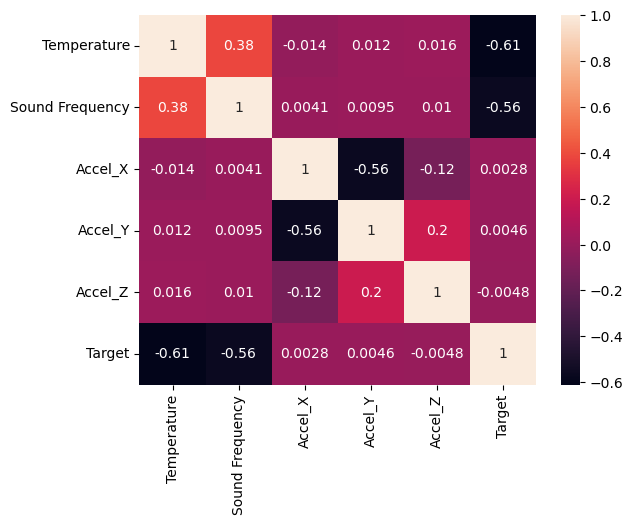

In [310]:
sns.heatmap(df_hi.drop(columns = ["Timestamp"]).corr() ,annot = True)

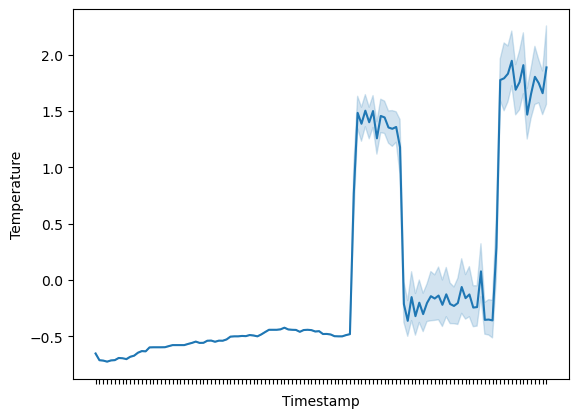

In [314]:
sns.lineplot(data = df_hi, x = "Timestamp" , y = "Temperature")
plt.gca().set_xticklabels([])  # Remove x-axis labels
plt.show()

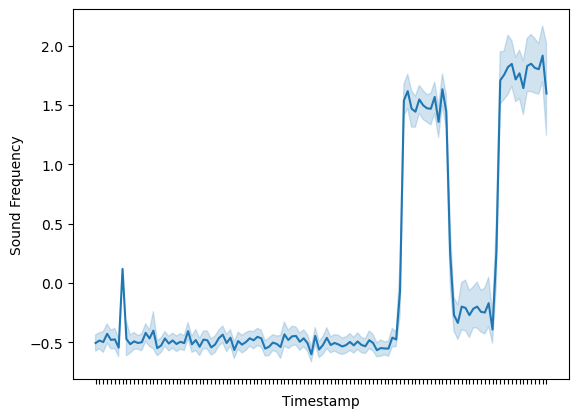

In [315]:
sns.lineplot(data = df_hi, x = "Timestamp" , y = "Sound Frequency")
plt.gca().set_xticklabels([])  # Remove x-axis labels
plt.show()

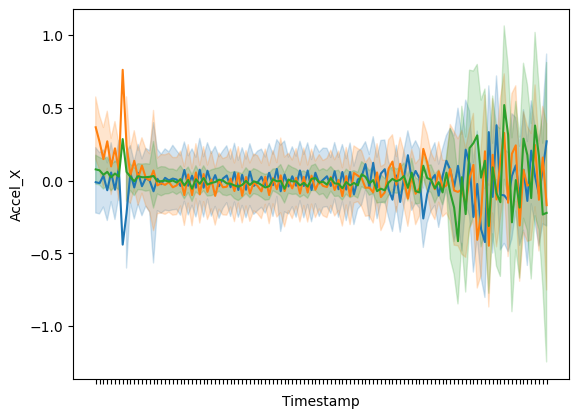

In [316]:
sns.lineplot(data = df_hi, x = "Timestamp" , y = "Accel_X")
sns.lineplot(data = df_hi, x = "Timestamp" , y = "Accel_Y")
sns.lineplot(data = df_hi, x = "Timestamp" , y = "Accel_Z")
plt.gca().set_xticklabels([])  # Remove x-axis labels
plt.show()

In [230]:
df_hi = df
label_encoder = LabelEncoder()
df_hi['Target'] = label_encoder.fit_transform(df_hi['Target'])

In [231]:
# Apply feature scailing first
cat_col = ["Target", "Timestamp"]
num_col = df_hi.drop(columns  = cat_col).columns

In [232]:
scaler = StandardScaler()

In [233]:
# Fit and transform the numerical columns
df_hi.loc[:, num_col] = scaler.fit_transform(df_hi[num_col])

In [236]:
df_hi

,Timestamp,Temperature,Sound Frequency,Accel_X,Accel_Y,Accel_Z,Target
0,27/09/2024 20:59,-0.596598,-0.419282,-0.021441,0.649251,-0.053195,1
1,27/09/2024 20:59,-0.596598,-0.042133,-0.964029,1.318845,0.284864,1
2,27/09/2024 20:59,-0.596598,0.010026,-1.173494,0.984048,0.115834,1
3,27/09/2024 20:59,-0.596598,-0.700138,-1.278226,1.318845,0.115834,1
4,27/09/2024 20:59,-0.596598,-0.507551,-0.335637,0.872449,0.284864,1
...,...,...,...,...,...,...,...
6814,27/09/2024 23:04,2.159907,1.446404,-0.230905,-1.694327,-2.419609,0
6815,27/09/2024 23:04,3.101390,2.220763,1.340076,-0.466739,-3.602816,0
6816,27/09/2024 23:04,2.344321,0.688093,-0.649833,-3.033515,-2.419609,0
6817,27/09/2024 23:04,1.596959,0.840557,-0.021441,-0.020343,2.820307,0


#### Checking the Data Distribution

<Axes: xlabel='Target', ylabel='count'>

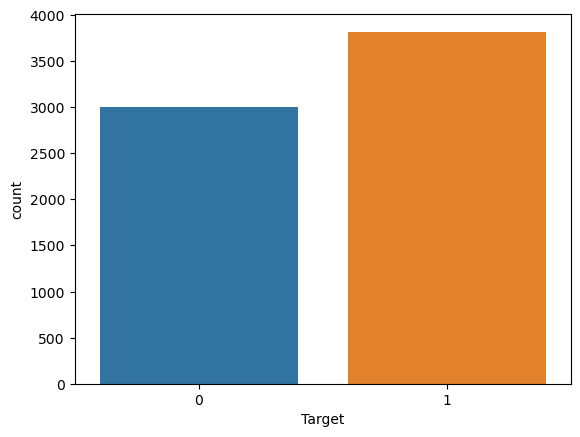

In [293]:
sns.countplot(df_hi , x = "Target")

In [237]:
X = df_hi.drop(columns = ["Target", "Timestamp"])
y =  df_hi["Target"]

In [295]:
kmeans_plus = KMeans(n_clusters=2, init='k-means++', n_init=1, random_state=0)
kmeans_plus.fit(X)

KMeans(n_clusters=2, n_init=1, random_state=0)

In [296]:
cluster_labels = kmeans_plus.labels_

In [299]:
ari = adjusted_rand_score(y, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

ami = adjusted_mutual_info_score(y, cluster_labels)
print(f"Adjusted Mutual Information (NMI): {ami}")

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, cluster_labels)
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Adjusted Rand Index (ARI): 0.4164890092749043
Adjusted Mutual Information (NMI): 0.44388428352431997
Homogeneity: 0.4085605362042239
Completeness: 0.48604910955486086
V-Measure: 0.44394890165268025


In [238]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [244]:
# Evaluate Models
def evaluate_model(y_true, y_pred, model, model_name):
    print(f"Performance metrics for {model_name}:")
    
    # Calculate and print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    print("=" * 50)

#### Logistic Regression

In [239]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],                
    'solver': ['liblinear','newton-cholesky', 'lbfgs','sag' , 'saga' , 'newton-cg'],
    'multi_class' :['auto', 'ovr'], 
    'max_iter' :[100,200,300,400]
}

In [241]:
grid_search_lr = GridSearchCV(
    estimator= LogisticRegression(),
    param_grid=param_grid_lr,
    cv=5,                
    n_jobs=-1,          
    verbose=3            
)

In [242]:
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['auto', 'ovr'],
                         'solver': ['liblinear', 'newton-cholesky', 'lbfgs',
                                    'sag', 'saga', 'newton-cg']},
             verbose=3)

In [243]:
# Best parameters and score
print("Best parameters found: ", grid_search_lr.best_params_)
print("Best cross-validation score: ", grid_search_lr.best_score_)

Best parameters found:  {'C': 1, 'multi_class': 'auto', 'solver': 'liblinear'}
Best cross-validation score:  0.9212229576212586


In [245]:
y_pred_lr_grid = grid_search_lr.predict(X_test)

In [246]:
evaluate_model(y_test, y_pred_lr_grid, grid_search_lr, "Logistic Regression Tuning")

Performance metrics for Logistic Regression Tuning:
Accuracy: 0.9208
Confusion Matrix:
[[ 729  158]
 [   4 1155]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       887
           1       0.88      1.00      0.93      1159

    accuracy                           0.92      2046
   macro avg       0.94      0.91      0.92      2046
weighted avg       0.93      0.92      0.92      2046



#### SVM

In [272]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],                 
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'decision_function_shape' :['ovo', 'ovr']
}

In [271]:
grid_search_svm = GridSearchCV(
    estimator= SVC(kernel = 'rbf', probability = True),
    param_grid=param_grid_svm,
    cv=5,                
    n_jobs=-1,          
    verbose=2            
)

In [273]:
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1]},
             verbose=2)

In [274]:
# Best parameters and score
print("Best parameters found: ", grid_search_svm.best_params_)
print("Best cross-validation score: ", grid_search_svm.best_score_)

Best parameters found:  {'C': 100, 'decision_function_shape': 'ovo', 'gamma': 'scale'}
Best cross-validation score:  0.9960194057536743


In [275]:
y_pred_svm_grid = grid_search_svm.predict(X_test)

In [276]:
evaluate_model(y_test, y_pred_svm_grid, grid_search_svm, "SVM Tuning")

Performance metrics for SVM Tuning:
Accuracy: 0.9917
Confusion Matrix:
[[ 870   17]
 [   0 1159]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       887
           1       0.99      1.00      0.99      1159

    accuracy                           0.99      2046
   macro avg       0.99      0.99      0.99      2046
weighted avg       0.99      0.99      0.99      2046



#### Random Forest

In [256]:
param_grid_rf = {
    'n_estimators': [50, 100, 200,300],
    'max_features': ['sqrt', 'log2',None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10,20],
    'min_samples_leaf': [1, 2, 4,8]
}

In [257]:
grid_search_rf = GridSearchCV(
    estimator= RandomForestClassifier(),
    param_grid=param_grid_rf,
    cv=5,                
    n_jobs=-1,          
    verbose=2            
)

In [258]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [259]:
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score: ", grid_search_rf.best_score_)

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score:  0.9941341499555468


In [263]:
y_pred_rf_grid = grid_search_rf.predict(X_test)

In [264]:
evaluate_model(y_test, y_pred_rf_grid, grid_search_rf, "Random Forest Tuning")

Performance metrics for Random Forest Tuning:
Accuracy: 0.9917
Confusion Matrix:
[[ 870   17]
 [   0 1159]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       887
           1       0.99      1.00      0.99      1159

    accuracy                           0.99      2046
   macro avg       0.99      0.99      0.99      2046
weighted avg       0.99      0.99      0.99      2046



#### Voting Classifier

In [279]:
voting_clf = VotingClassifier(estimators=[
    ('svm', grid_search_svm),
    ('log_reg', grid_search_lr),
    ('rf', grid_search_rf)
], voting='soft')

In [280]:
voting_clf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


VotingClassifier(estimators=[('svm',
                              GridSearchCV(cv=5,
                                           estimator=SVC(probability=True),
                                           n_jobs=-1,
                                           param_grid={'C': [0.1, 1, 10, 100],
                                                       'decision_function_shape': ['ovo',
                                                                                   'ovr'],
                                                       'gamma': ['scale',
                                                                 'auto', 0.01,
                                                                 0.1, 1]},
                                           verbose=2)),
                             ('log_reg',
                              GridSearchCV(cv=5, estimator=LogisticRegression(),
                                           n_jobs=-1,
                                           param_grid={'C': [0.01, 0.1, 1, 10,
                                                             100],
                                                       'multi_class': ['auto',
                                                                       'ovr'],
                                                       'solver': ['liblinear',
                                                                  'newton-cholesky',
                                                                  'lbfgs',
                                                                  'sag', 'saga',
                                                                  'newton-cg']},
                                           verbose=3)),
                             ('rf',
                              GridSearchCV(cv=5,
                                           estimator=RandomForestClassifier(),
                                           n_jobs=-1,
                                           param_grid={'max_depth': [None, 10,
                                                                     20, 30],
                                                       'max_features': ['sqrt',
                                                                        'log2',
                                                                        None],
                                                       'min_samples_leaf': [1,
                                                                            2,
                                                                            4,
                                                                            8],
                                                       'min_samples_split': [2,
                                                                             5,
                                                                             10,
                                                                             20],
                                                       'n_estimators': [50, 100,
                                                                        200,
                                                                        300]},
                                           verbose=2))],
                 voting='soft')

In [281]:
y_pred_voting = voting_clf.predict(X_test)

In [282]:
evaluate_model(y_test, y_pred_voting,voting_clf, "Voting Classifier")

Performance metrics for Voting Classifier:
Accuracy: 0.9892
Confusion Matrix:
[[ 865   22]
 [   0 1159]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       887
           1       0.98      1.00      0.99      1159

    accuracy                           0.99      2046
   macro avg       0.99      0.99      0.99      2046
weighted avg       0.99      0.99      0.99      2046



#### Confusion matrix of Random Forest and SVM (both models yield the same results)

In [317]:
cm = confusion_matrix(y_test, y_pred_rf_grid)

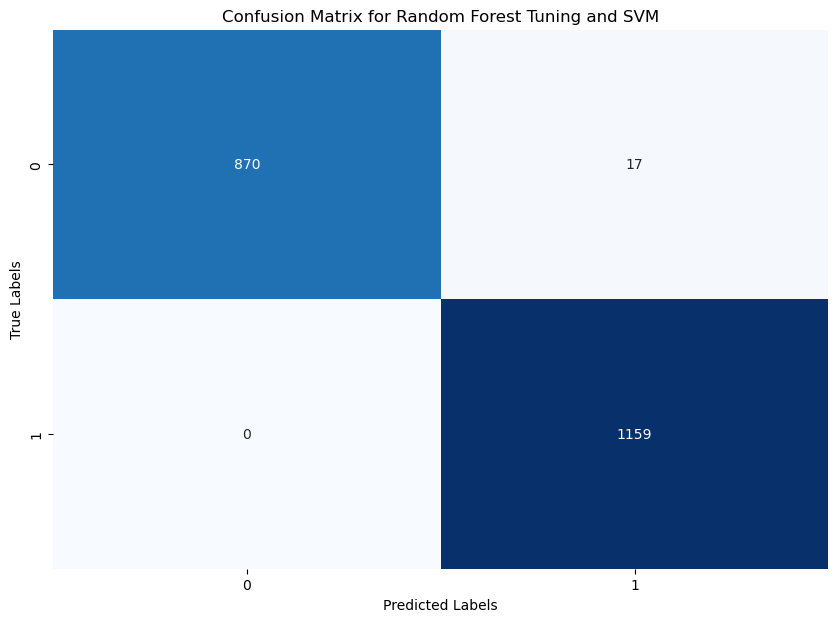

In [321]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=unique_labels(y_test), yticklabels=unique_labels(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Tuning and SVM')
plt.show()

In [304]:
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # Get the predicted probabilities
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability for the positive class

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)  # Calculate AUC

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plot diagonal line (chance line)
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

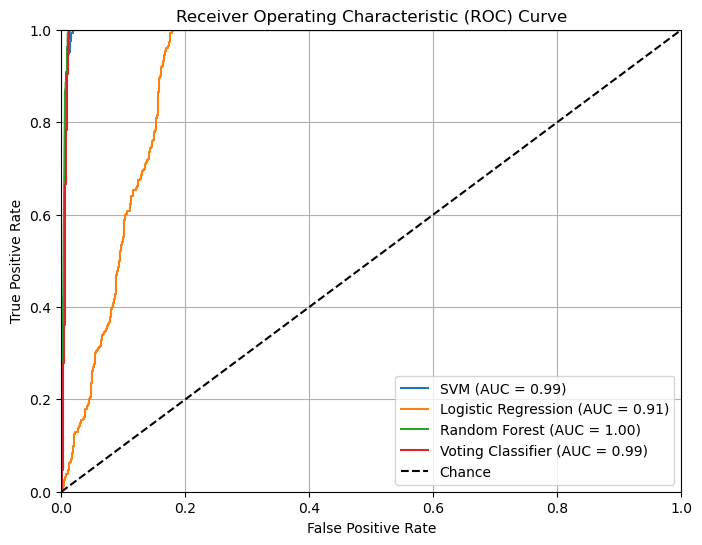

In [305]:
models = {
    'SVM': grid_search_svm.best_estimator_,
    'Logistic Regression': grid_search_lr.best_estimator_,
    'Random Forest': grid_search_rf.best_estimator_,
    'Voting Classifier': voting_clf
}
plot_roc_curve(models, X_test, y_test)